In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import cv2

from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

from utils import convert_image, center_crop, convert_to_y_channel
from models import Generator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Создадим генератор

In [2]:
n_blocks = 16
upscale_factor = 4

model = Generator(n_blocks=n_blocks, scaling_factor=upscale_factor)

Загрузим веса

In [3]:
# путь к весам моделей
srgan_checkpoint = "./weights/pretrained/SRGAN_16blocks_4x.pth"
srresnet_checkpoint = "./weights/pretrained/SRResNet_16blocks_4x.pth"

# поставьте checkpoint той модели, которую хотите протеститровать
model.load_state_dict(torch.load(srgan_checkpoint))
model.to(device)
model.eval()

print(device)

cuda


Загружаем json с тестовыми изображениями

In [7]:
with open('./jsons/DIV2K_valid_HR_test_images.json', 'rt') as f:
    test_images = json.loads(f.read())

Выберем изображение для проверки, затем уменьшим и получим low resolution изображение

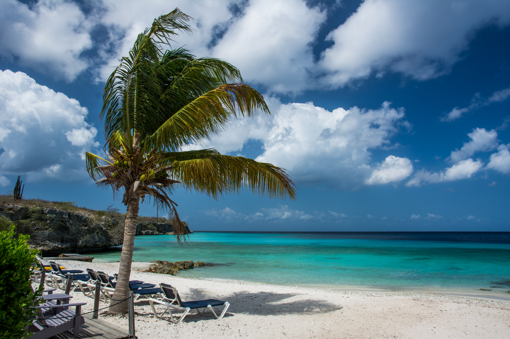

In [23]:
downscale_multiplier = 4 # во сколько раз уменьшить изначальное изображение

img_path = test_images[2]
hr_img = Image.open(img_path, mode="r").convert('RGB')
lr_img = hr_img.resize((hr_img.width//downscale_multiplier, hr_img.height//downscale_multiplier), Image.BICUBIC)
lr_img

Увеличиваем изображение разными способами

In [18]:
# увеличение изображения обычной бикубической интерполяцией
bicubic_img = lr_img.resize((lr_img.width*4, lr_img.height*4), Image.BICUBIC)

# увеличение изображения с помощью нейросети!
sr_img = model(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
sr_img = torch.clamp(sr_img.squeeze(0).cpu().detach(),-1,1)
sr_img = convert_image(sr_img, source='[-1, 1]', target='pil')

Посмотрим результат!

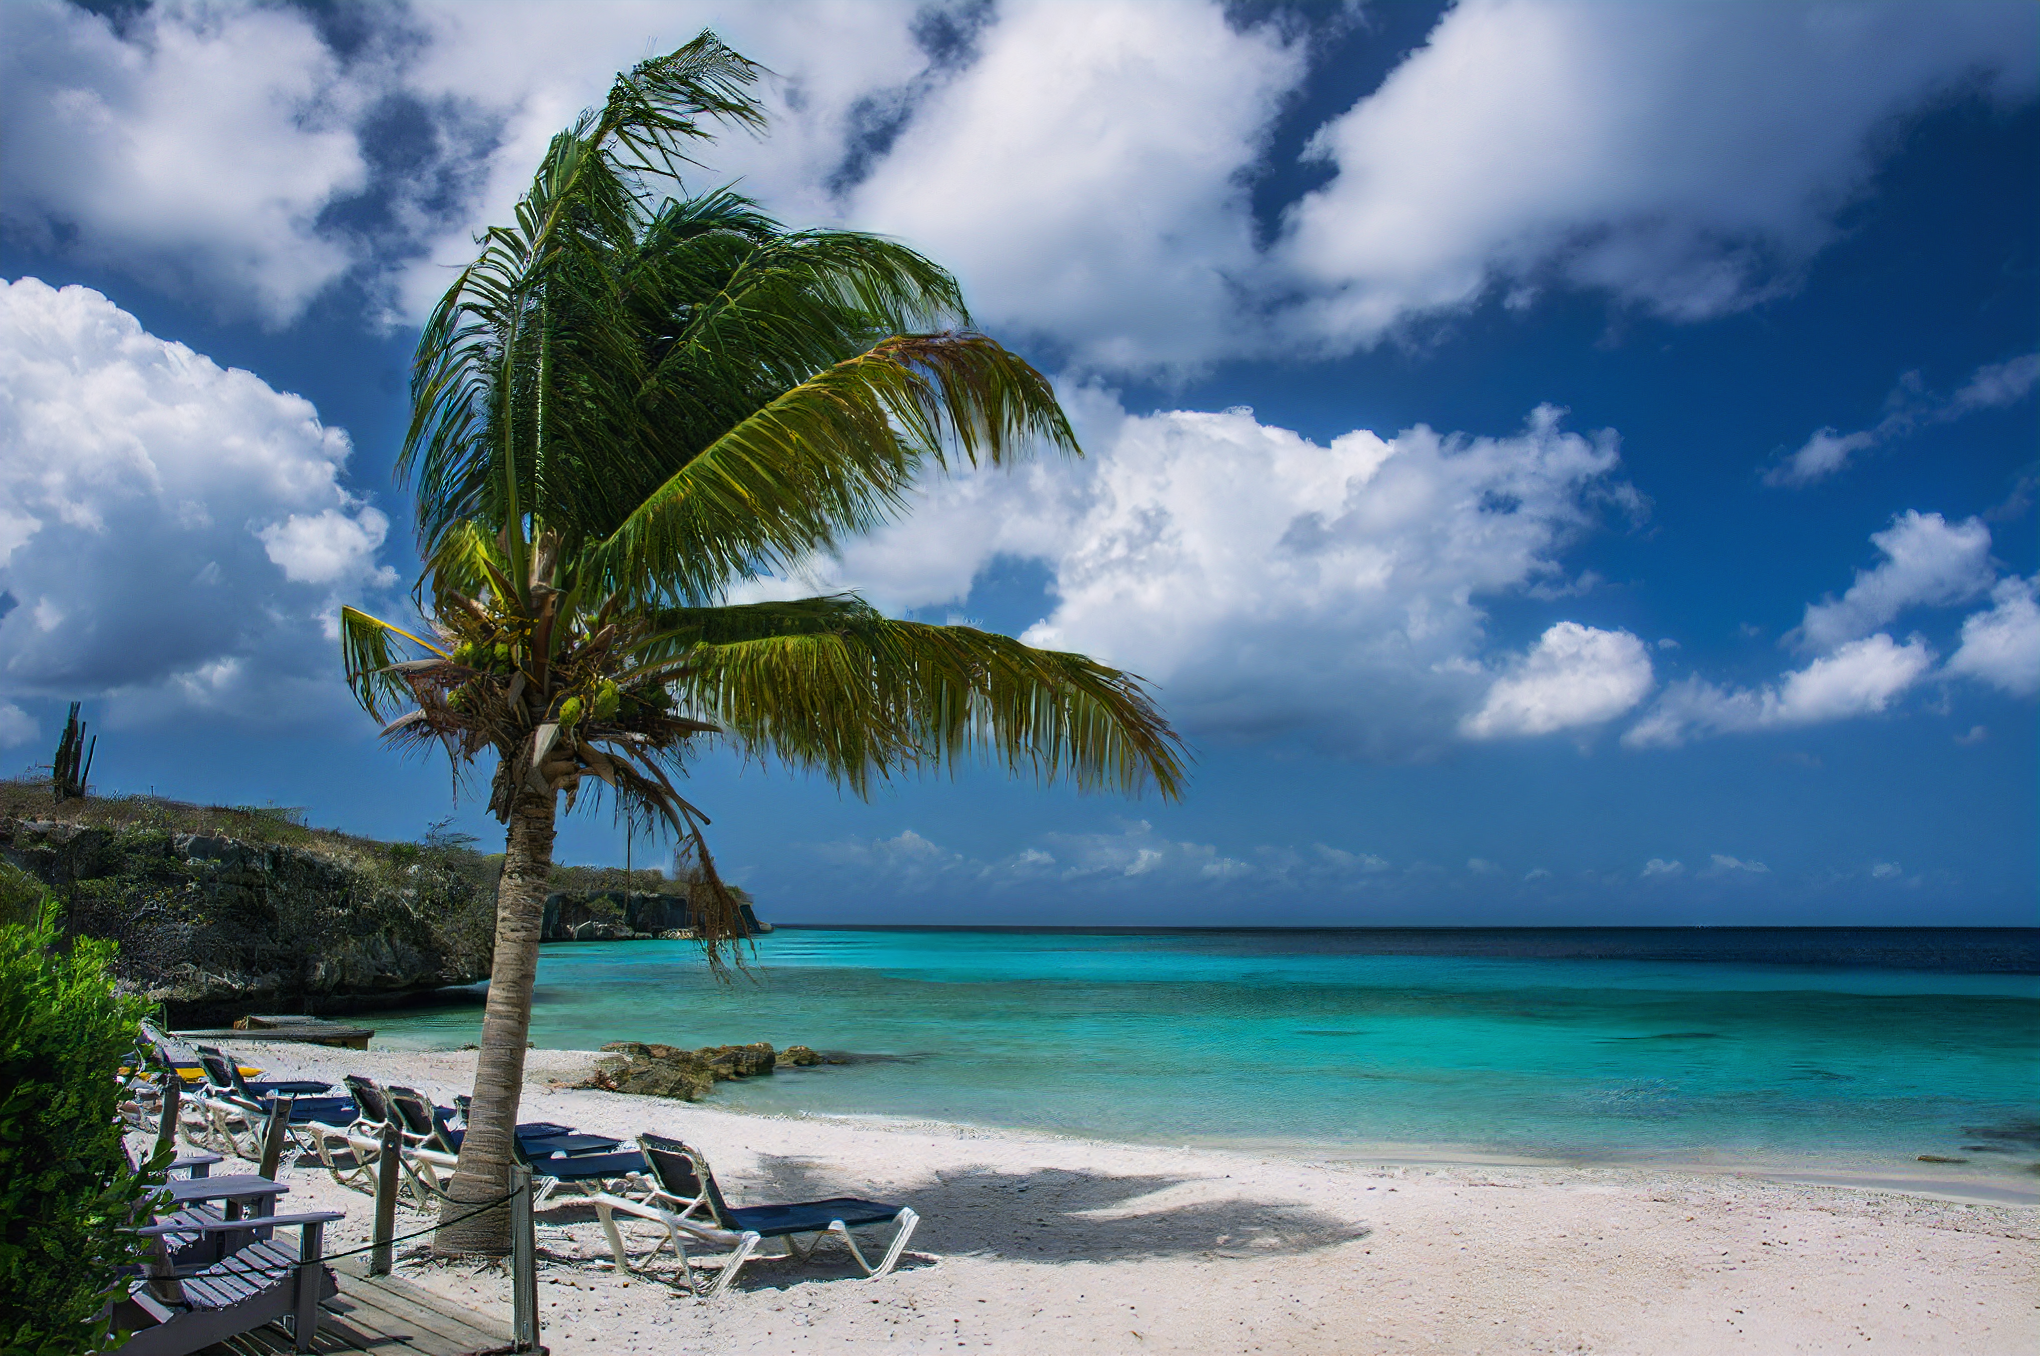

In [22]:
sr_img

Сохраним изображения

In [20]:
lr_img.save('./images/lr_image.png')
bicubic_img.save('./images/bicubic_image.png')
sr_img.save('./images/sr_image.png')

Проверим качество результата с помощью метрики [SSIM](https://ru.wikipedia.org/wiki/SSIM). <br>

In [21]:
sr_img_y = convert_to_y_channel(sr_img)
bicubic_y = convert_to_y_channel(bicubic_img)
hr_img_y = convert_to_y_channel(hr_img)

print('structure similarity on super resolution image:', SSIM(sr_img_y, hr_img_y, data_range=255.))
print('structure similarity on bicubic interpolation image:', SSIM(bicubic_y, hr_img_y, data_range=255.))

structure similarity on super resolution image: 0.7288548606467301
structure similarity on bicubic interpolation image: 0.8232913082172139


Эти метрики основаны на MSE, поэтому SRResNet показывает на них качество лучше, чем SRGAN. Однако такая оценка не совпадает с реальным качеством, поэтому ориентироваться на эту метрику не стоит.  

Поздравляю! У вас получилось обучить нейросеть, которая делает Super Resolution изображений!